# **볼린저밴드를 이용한 반전 매매 기법**
* 참고: https://youtu.be/cd-V86nLVog

In [ ]:
!pip install yfinance --quiet
!pip install git+https://github.com/quantopian/pyfolio --quiet

     |████████████████████████████████| 6.3 MB 33.5 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 


In [ ]:
import yfinance as yf # 주가데이터 가져오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyfolio as pf
import datetime
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# **투자모형 REVIEW**
* 매수 시그널: %b가 0.05 보다 작고, IIP21(21일 일중 강도율)이 0보다 클 때 (**저점**이라고 판단)
* 매도 시그널: %b가 0.95 보다 크고, IIP21(21일 일중 강도율)이 0보다 작을 때 (**고점**이라고 판단)
* 시그널 그대로: 현 상태 유지
* 매수: 투자금 전액 매수
* 매도: 투자금 전액 매도

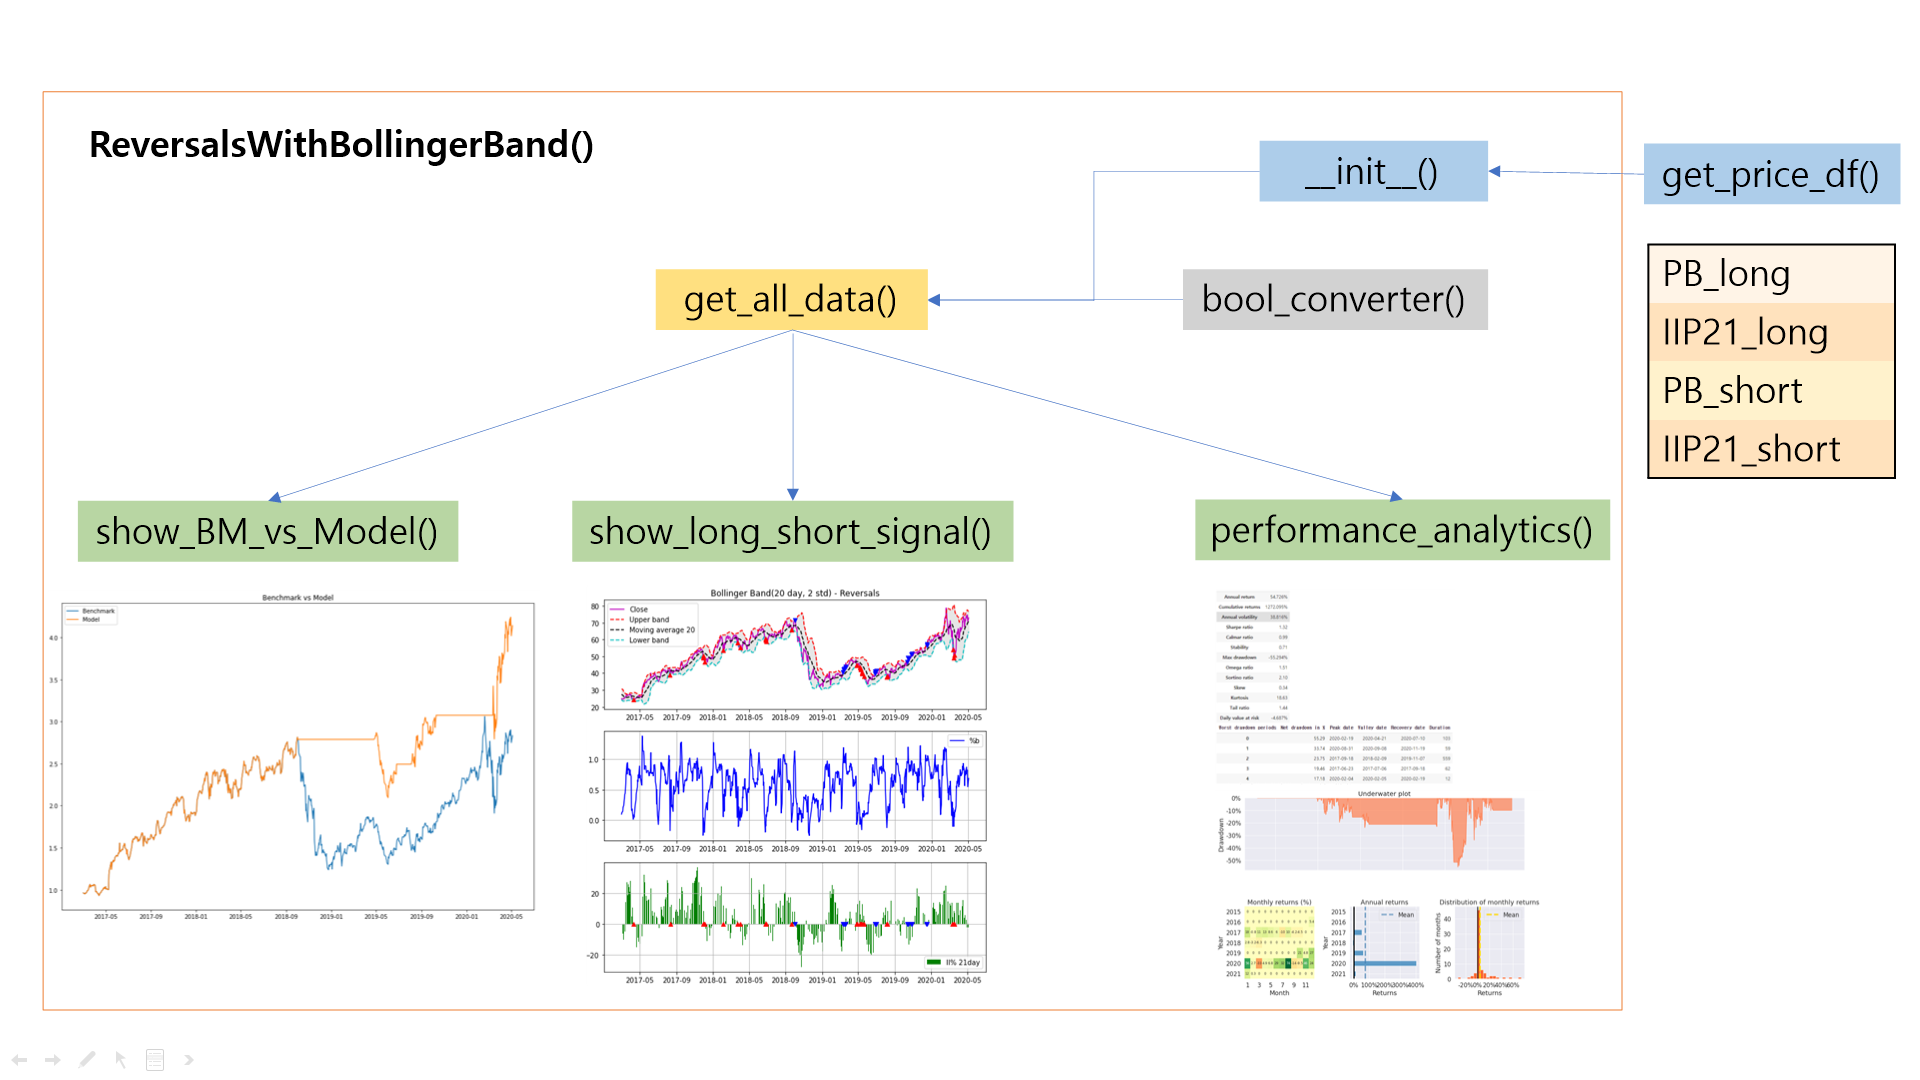

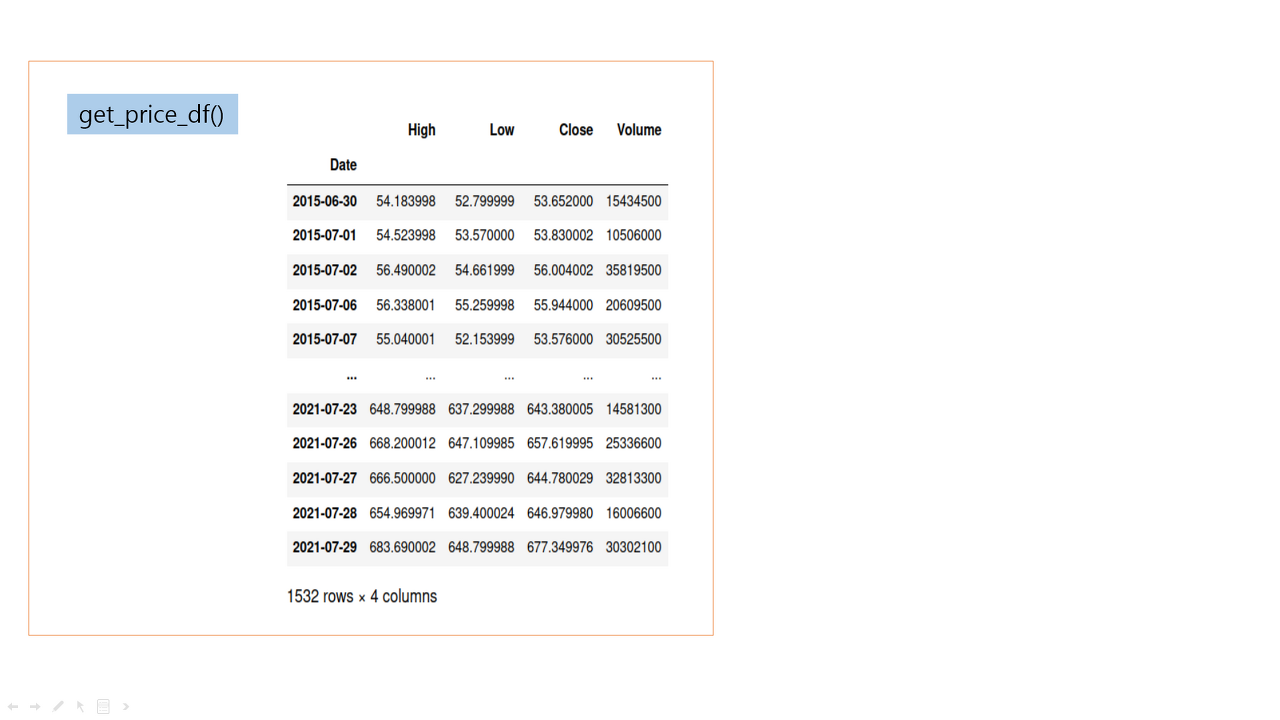

In [ ]:
Image('get_price_df.png')

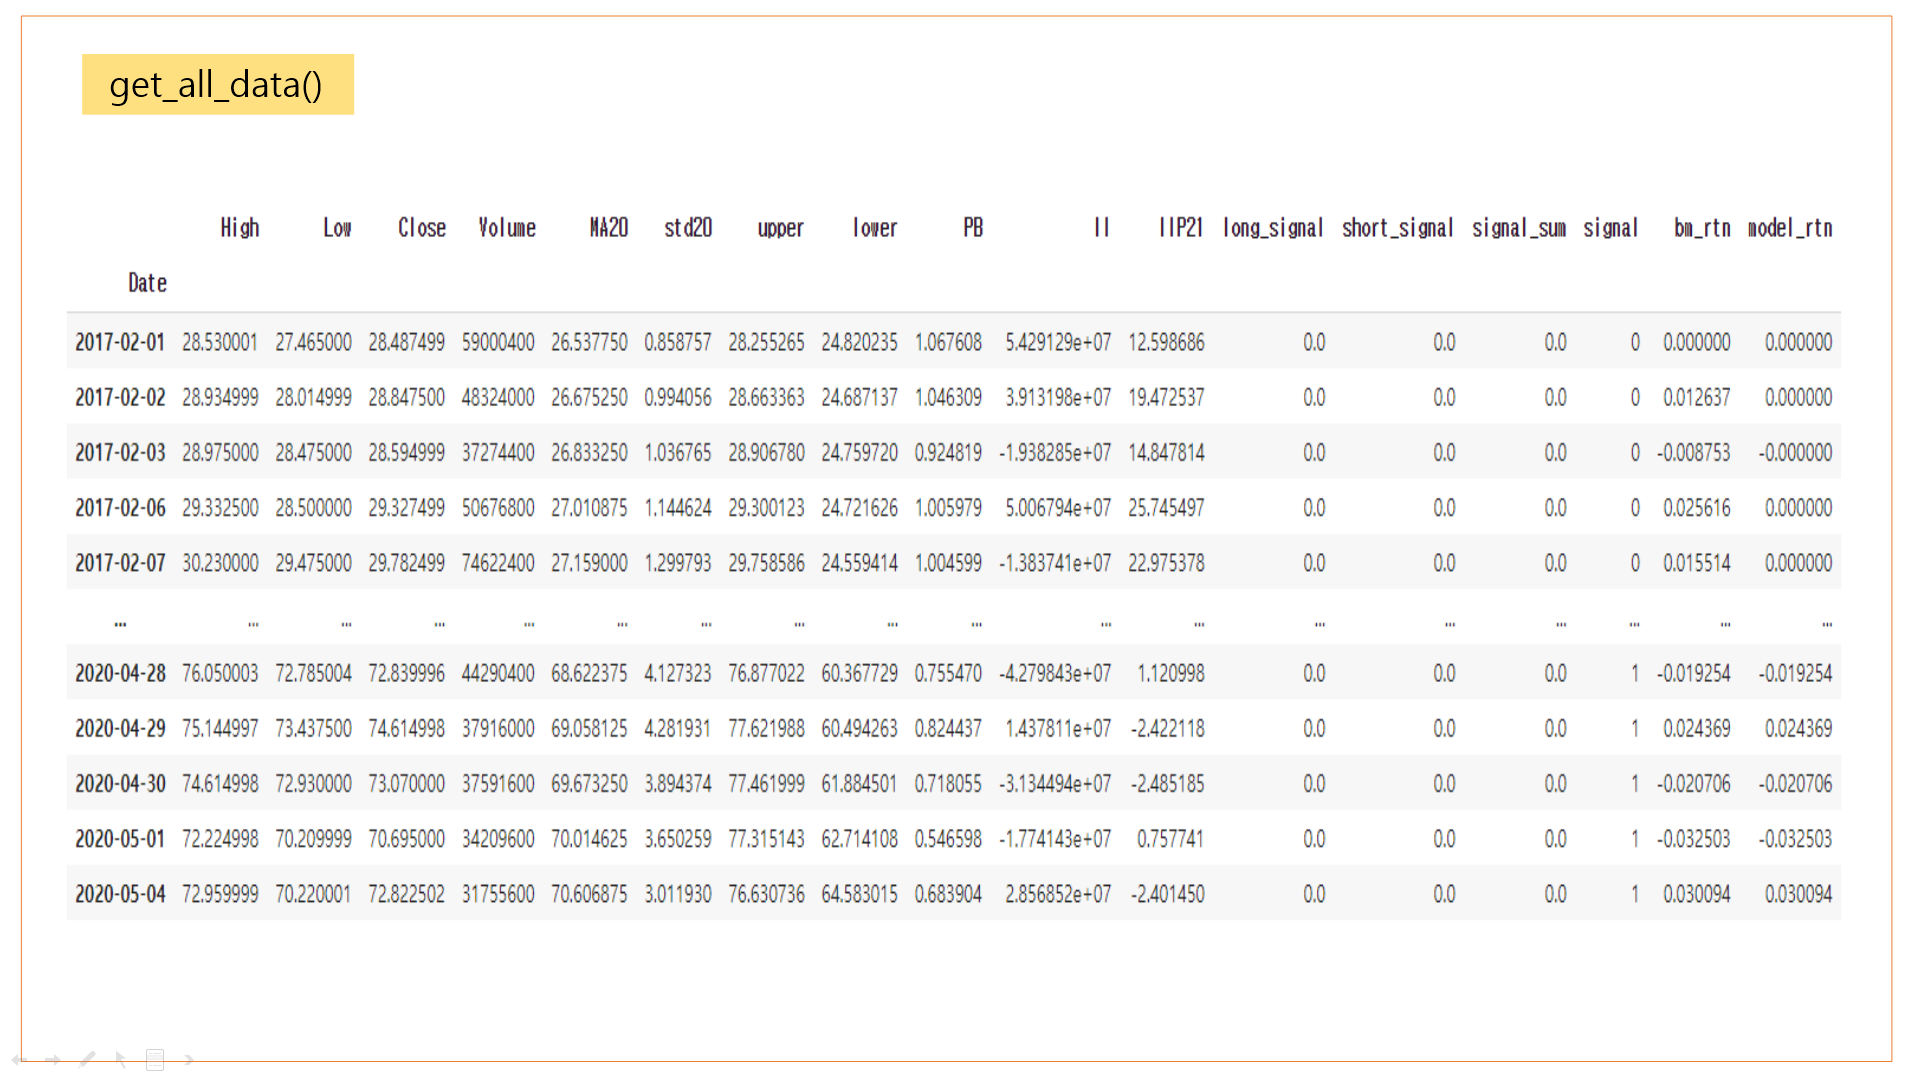

* PB(%b): 주가가 볼린저 밴드 어디에 위치하는지를 나타내는 지표
   * %b = (종가-하단 볼린저 밴드) / (상단 볼린저 밴드 - 하단 볼린저 밴드)
   * %b = 1이면 종가가 상단 밴드에, 0.5이면 종가가 MA20에, 0이면 종가가 하단 밴드에 있음.
* II(일중 강도): 거래량 지표. 거래 범위에서 종가의 위치를 토대로 주식 종목의 자금 흐름을 설명함. II는 장이 끝나는 시점에서 트레이더들의 움직임을 나타내는데, 종가가 거래 범위 천정권에서 형성되면 1, 중간에서 형성되면 0, 바닥권에서 형성되면 -1임. 
    * 일중 강도 = ((2*종가 - 고가 - 저가)/(고가 - 저가)) * 100
* 일중 강도율: 21일 기간 동안의 II 합을 21일 기간 동안의 거래량 합으로 나누어 표준화한 것.
    * 일중 강도율 = (일중강도의 21일 합 / 거래량의 21일 합) * 100

# **백테스트 클래스와 함수**

In [ ]:
def get_price_df(ticker, start_date, end_date = datetime.datetime.now().strftime('%Y-%m-%d')):
    """Returns High, Low, Close, Volume dataframe
    Parameters
    ----------
    ticker : string
    start_date : string
    end_date : string
        
    Returns
    -------
    df : dataframe
    """
    df = yf.download(ticker, start_date,end_date)
    df.drop(columns = ['Open','Adj Close'],inplace = True) # 필요없는 column 빼기
    return df

In [ ]:
class ReversalsWithBollingerBand:
    def __init__(self, High_Low_Close_Volume_df, PB_long = 0.05, IIP21_long = 0, PB_short = 0.95, IIP21_short = 0):
        self.all_data = self.get_all_data(High_Low_Close_Volume_df, PB_long, IIP21_long, PB_short, IIP21_short)
        self.show_BM_vs_Model(self.all_data[['bm_rtn', 'model_rtn']])
        self.show_long_short_signal(self.all_data[['Close','MA20','upper', 'lower','PB','IIP21']], PB_long, IIP21_long, PB_short, IIP21_short)
        self.performance_analytics(self.all_data['model_rtn']) 
    
    def get_all_data(self, High_Low_Close_Volume_df, PB_long, IIP21_long, PB_short, IIP21_short):
        """Returns Indicators
        
        Paramters
        ---------
        prices : dataframe
            'High, Low, Close, Volume' data
            
        Returns
        -------
        returns : dataframe
            basic data and indicator data
        """
        df = High_Low_Close_Volume_df
        df['MA20'] = df['Close'].rolling(window=20).mean() 
        df['std20'] = df['Close'].rolling(window=20).std() 
        df['upper'] = df['MA20'] + (df['std20'] * 2)
        df['lower'] = df['MA20'] - (df['std20'] * 2)
        df['PB'] = (df['Close'] - df['lower']) / (df['upper'] - df['lower'])

        df['II'] = (2*df['Close']-df['High']-df['Low'])/(df['High']-df['Low'])*df['Volume']
        df['IIP21'] = df['II'].rolling(window=21).sum()/df['Volume'].rolling(window=21).sum()*100
        df = df.dropna()

        long_signal = ((df[['PB']] < PB_long).applymap(self.bool_converter))['PB'] + ((df[['IIP21']] > IIP21_long).applymap(self.bool_converter))['IIP21']
        short_signal = (-(df[['PB']]>PB_short).applymap(self.bool_converter))['PB'] + (-(df[['IIP21']] < IIP21_short).applymap(self.bool_converter))['IIP21']
        long_signal = (long_signal.replace(1,0) )/2 # long_signal은 2일 때 매수시그널(1과 0은 무시)
        short_signal = (short_signal.replace(-1,0))/2 # short_signal은 -2일 때만 매도 시그널 (-1과 0은 무시) 

        df['long_signal'] = long_signal # 매수시그널이면 1, 아니면 0
        df['short_signal'] = short_signal # 매도시그널이면 -1, 아니면 0
        df['signal_sum'] = long_signal + short_signal # 1이면 매수, 0 이면 그대로, -1이면 매도 시그널
        df['signal']=0 # 투자하고 있으면 1, 투자안하고 있으면 0


        for i, sig in enumerate(df.signal_sum):
          conditions = [ (i==0), (sig==0), (sig==1), (sig==-1)]
          choices = [0, df.signal[i-1], 1, 0]
          df['signal'][i] = np.select(conditions, choices, default = 0)

        df['bm_rtn'] = df[['Close']].pct_change() # Benchmark Daily Returns
        df['model_rtn']=df.signal.shift() * df.bm_rtn # Model Daily Returns

        df.bm_rtn.iloc[0] = 0
        df.model_rtn.iloc[0] = 0
        return df
    
    def show_BM_vs_Model(self, bm_model_rtns_df):
        """Benchmark vs Model
        Parameters
        ----------
        returns : dataframe
            'bm_rtn, model_rtn' data
            
        Returns
        -------
        None
        """
        wealth = (1 + bm_model_rtns_df).cumprod()
        cagr = (wealth.iloc[-1] / wealth.iloc[0])**(250/(len(wealth)-1)) - 1
        risk = bm_model_rtns_df.iloc[1:].std() * 250**0.5
        print(pd.DataFrame({'CAGR':cagr, '연변동성':risk}))

        plt.figure(figsize=(15,10))
        plt.title('Benchmark vs Model')
        plt.plot(wealth.index, wealth['bm_rtn'],  label='Benchmark')
        plt.plot(wealth.index, wealth['model_rtn'], label = 'Model')
        plt.legend(loc='best')
        plt.show()
        
    def show_long_short_signal(self, Close_MA20_upper_lower_PB_IIP21_df, PB_long, IIP21_long, PB_short, IIP21_short):
        """Show Long Short Signal
        Parameters
        ----------
        returns : dataframe
            'Close, MA20, upper, lower, %b, II% 21day' data
            
        Returns
        -------
        None
        """
        df = Close_MA20_upper_lower_PB_IIP21_df
        plt.figure(figsize=(15, 15))
        plt.subplot(3, 1, 1)
        plt.title('Bollinger Band(20 day, 2 std) - Reversals')
        plt.plot(df.index, df['Close'], 'm', label='Close')
        plt.plot(df.index, df['upper'], 'r--', label ='Upper band')
        plt.plot(df.index, df['MA20'], 'k--', label='Moving average 20')
        plt.plot(df.index, df['lower'], 'c--', label ='Lower band')
        plt.fill_between(df.index, df['upper'], df['lower'], color='0.9')
        for i in range(0, len(df.Close)):
            if df.PB.values[i] < PB_long and df.IIP21.values[i] > IIP21_long:       # ①
                plt.plot(df.index.values[i], df.Close.values[i], 'r^')  # ②
            elif df.PB.values[i] > PB_short and df.IIP21.values[i] < IIP21_short:     # ③
                plt.plot(df.index.values[i], df.Close.values[i], 'bv')  # ④
        plt.legend(loc='best')

        plt.subplot(3, 1, 2)
        plt.plot(df.index, df['PB'], 'b', label='%b')
        plt.grid(True)
        plt.legend(loc='best')

        plt.subplot(3, 1, 3)
        plt.bar(df.index, df['IIP21'], color='g', label='II% 21day')
        for i in range(0, len(df.Close)):
            if df.PB.values[i] < PB_long and df.IIP21.values[i] > IIP21_long:
                plt.plot(df.index.values[i], 0, 'r^') # ⑤
            elif df.PB.values[i] > PB_short and df.IIP21.values[i] < IIP21_short:
                plt.plot(df.index.values[i], 0, 'bv') # ⑥
        plt.grid(True)
        plt.legend(loc='best')
        plt.show()
        
    def performance_analytics(self, returns):
        """Returns Perforamnce Analytics using pyfolio package
        Parameters
        ----------
        returns : series
            backtestd portfolio returns
        Returns
        -------
        None
        """
        pf.create_returns_tear_sheet(returns)
    
    def bool_converter(self, bool_var):
        """Returns Integer Value from Boolean Value
        Parameters
        ----------
        bool_var : boolean
            Boolean variables representing trade signals
        Returns
        -------
        result : int
            Integer variables representing trade signals
        """
        if bool_var == True:
            result = 1
        elif bool_var == False:
            result = 0
        return result

# **투자모형 비틀기**

[*********************100%***********************]  1 of 1 completed
               CAGR     연변동성
bm_rtn     0.332219  0.48752
model_rtn  0.550269  0.36608


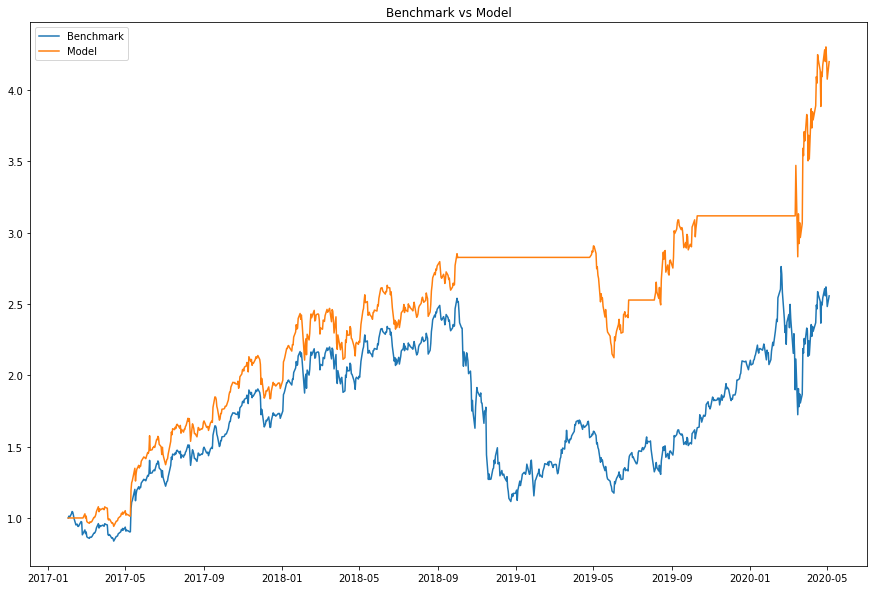

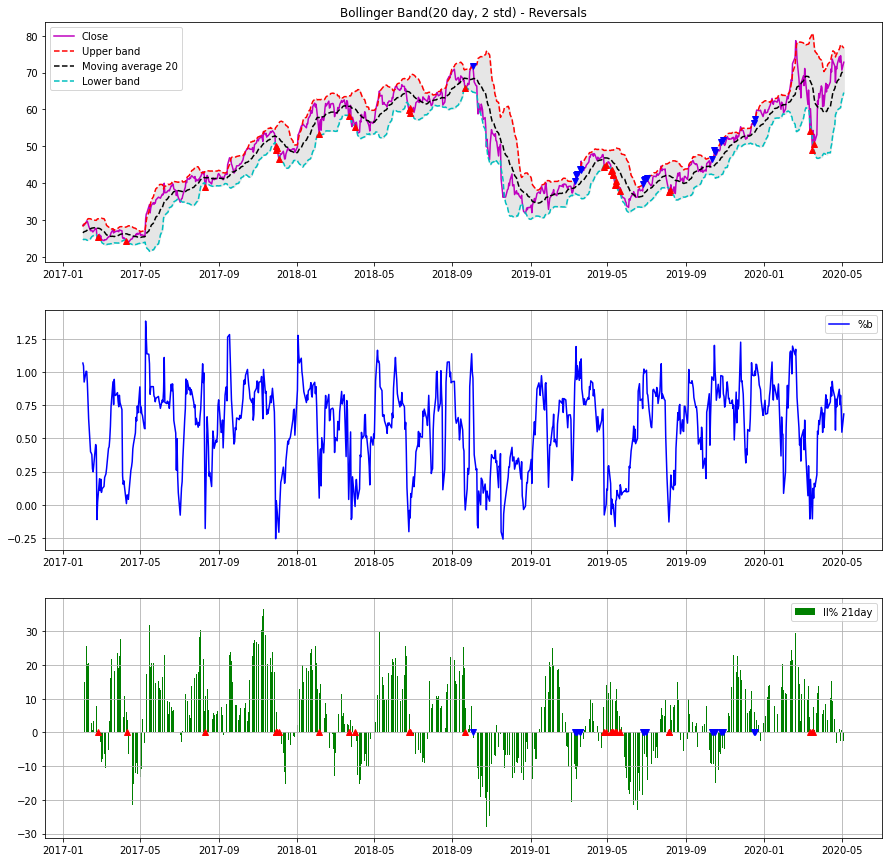

Start date,2017-02-01
End date,2020-05-04
Total months,39
,Backtest
Annual return,55.488%
Cumulative returns,319.77%
Annual volatility,36.732%
Sharpe ratio,1.38
Calmar ratio,2.06
Stability,0.78
Max drawdown,-26.972%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,26.97,2019-05-02,2019-06-03,2019-09-05,91
1,18.45,2020-03-13,2020-03-16,2020-03-24,8
2,14.46,2018-03-16,2018-04-06,2018-05-09,39
3,14.19,2017-11-24,2017-12-13,2018-01-08,32
4,13.43,2018-01-29,2018-02-05,2018-02-20,17


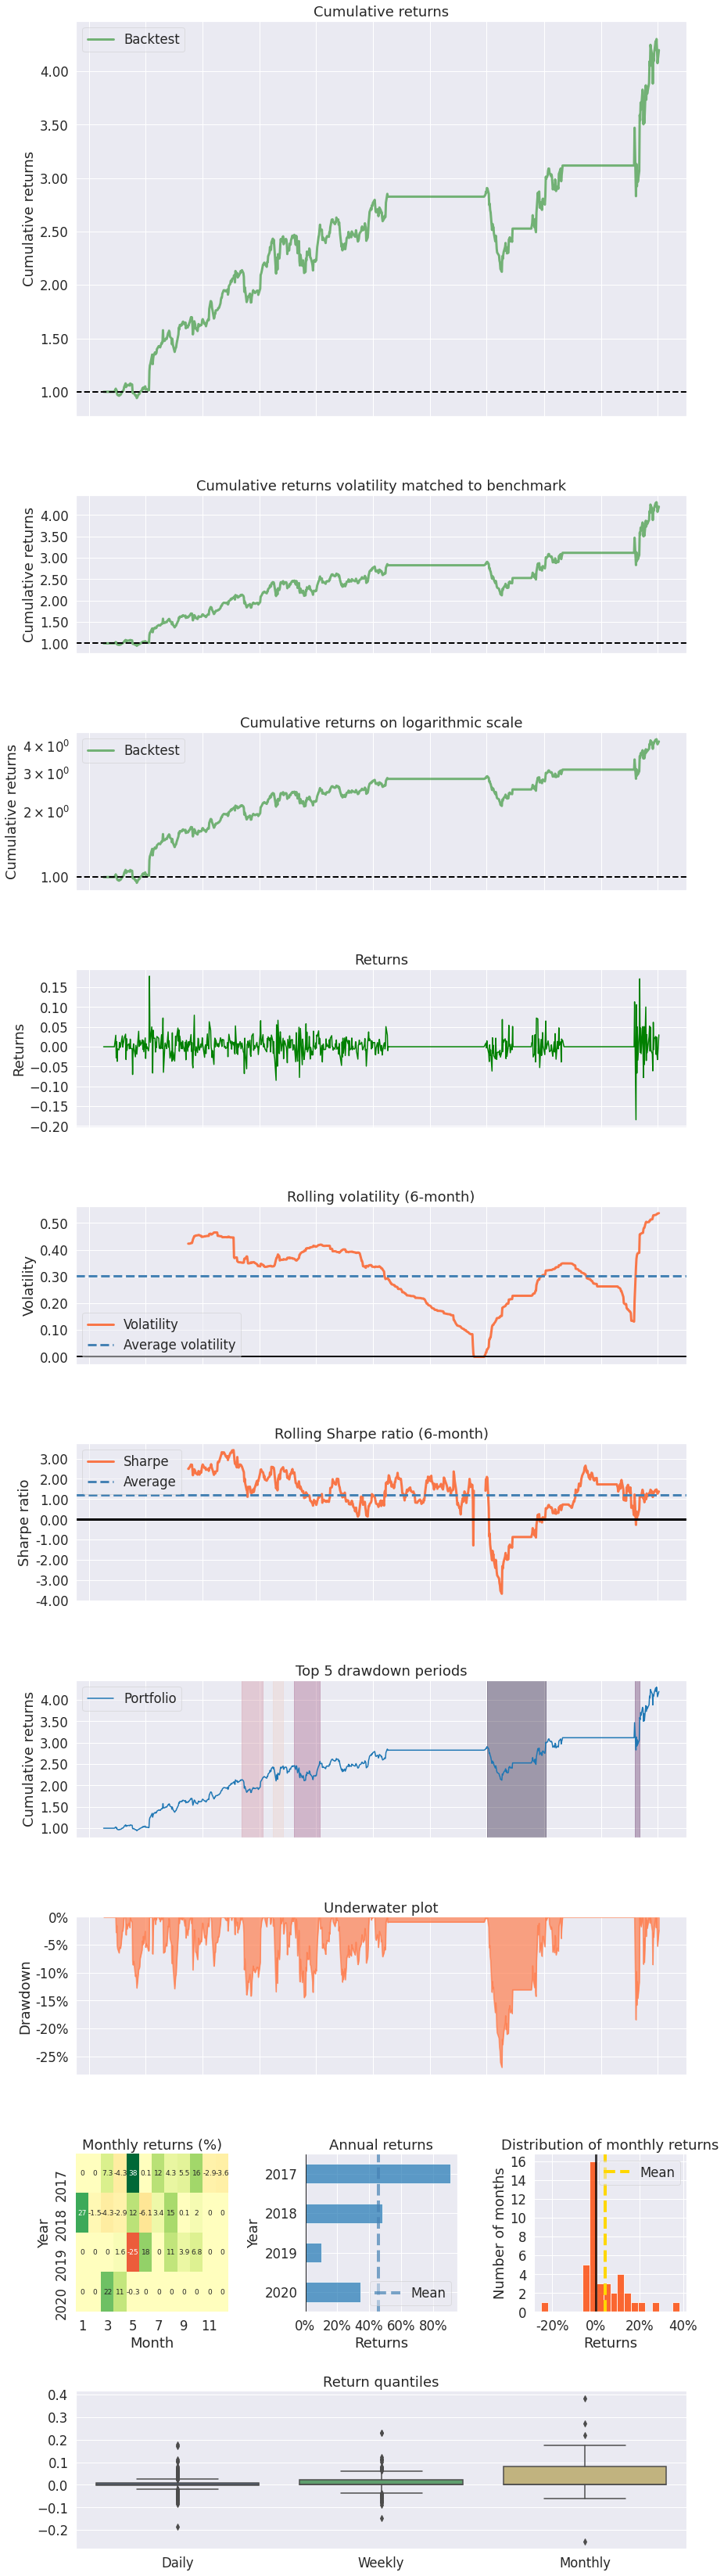

In [ ]:
ReversalsWithBollingerBand(get_price_df('NVDA', '2017-01-01', '2020-05-05') )# Nvidia stock

[*********************100%***********************]  1 of 1 completed
               CAGR      연변동성
bm_rtn    -0.076187  0.309432
model_rtn -0.036470  0.140470


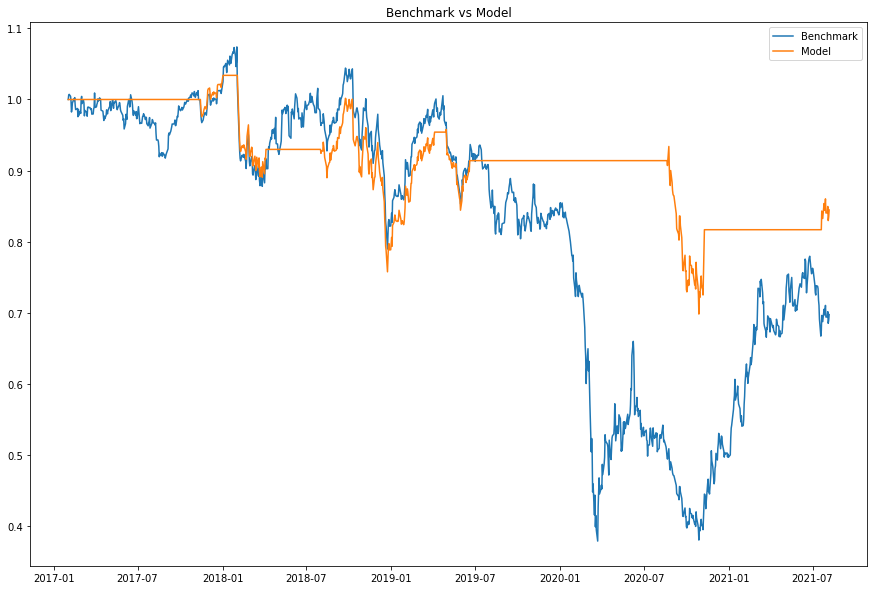

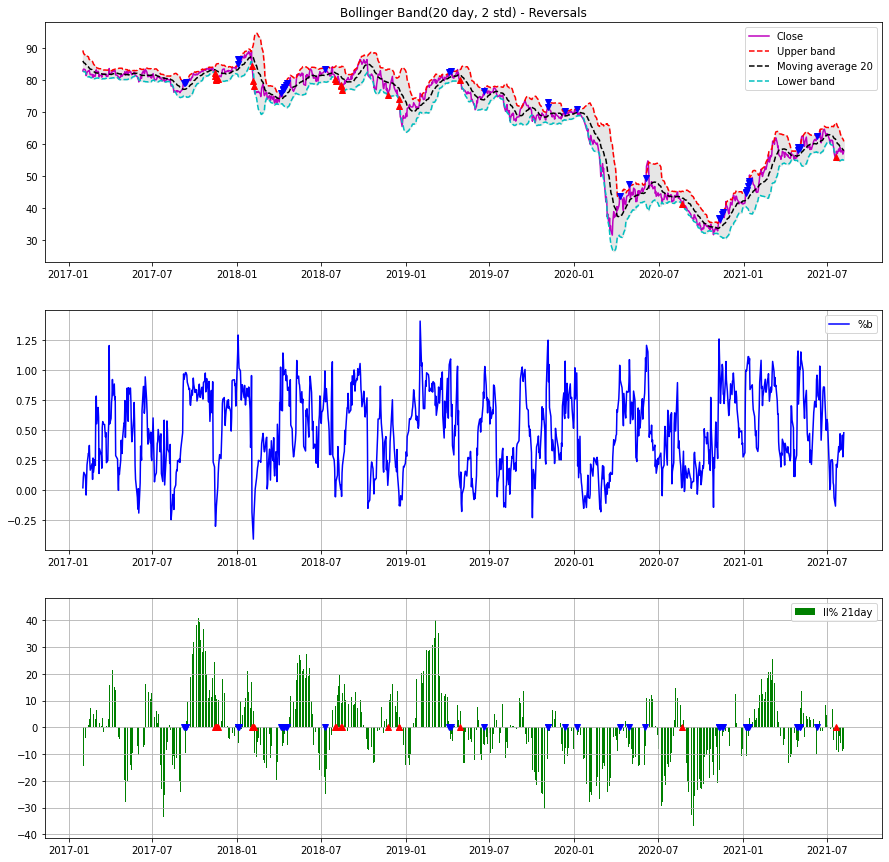

Start date,2017-02-01
End date,2021-08-06
Total months,54
,Backtest
Annual return,-3.672%
Cumulative returns,-15.534%
Annual volatility,14.097%
Sharpe ratio,-0.20
Calmar ratio,-0.11
Stability,0.67
Max drawdown,-32.456%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,32.46,2018-02-02,2020-10-28,NaT,NaN
1,2.43,2017-11-14,2017-11-17,2017-11-29,12
2,1.54,2017-12-04,2017-12-06,2017-12-21,14
3,0.45,2017-12-28,2017-12-29,2018-01-02,4
4,0.10,2017-12-26,2017-12-27,2017-12-28,3


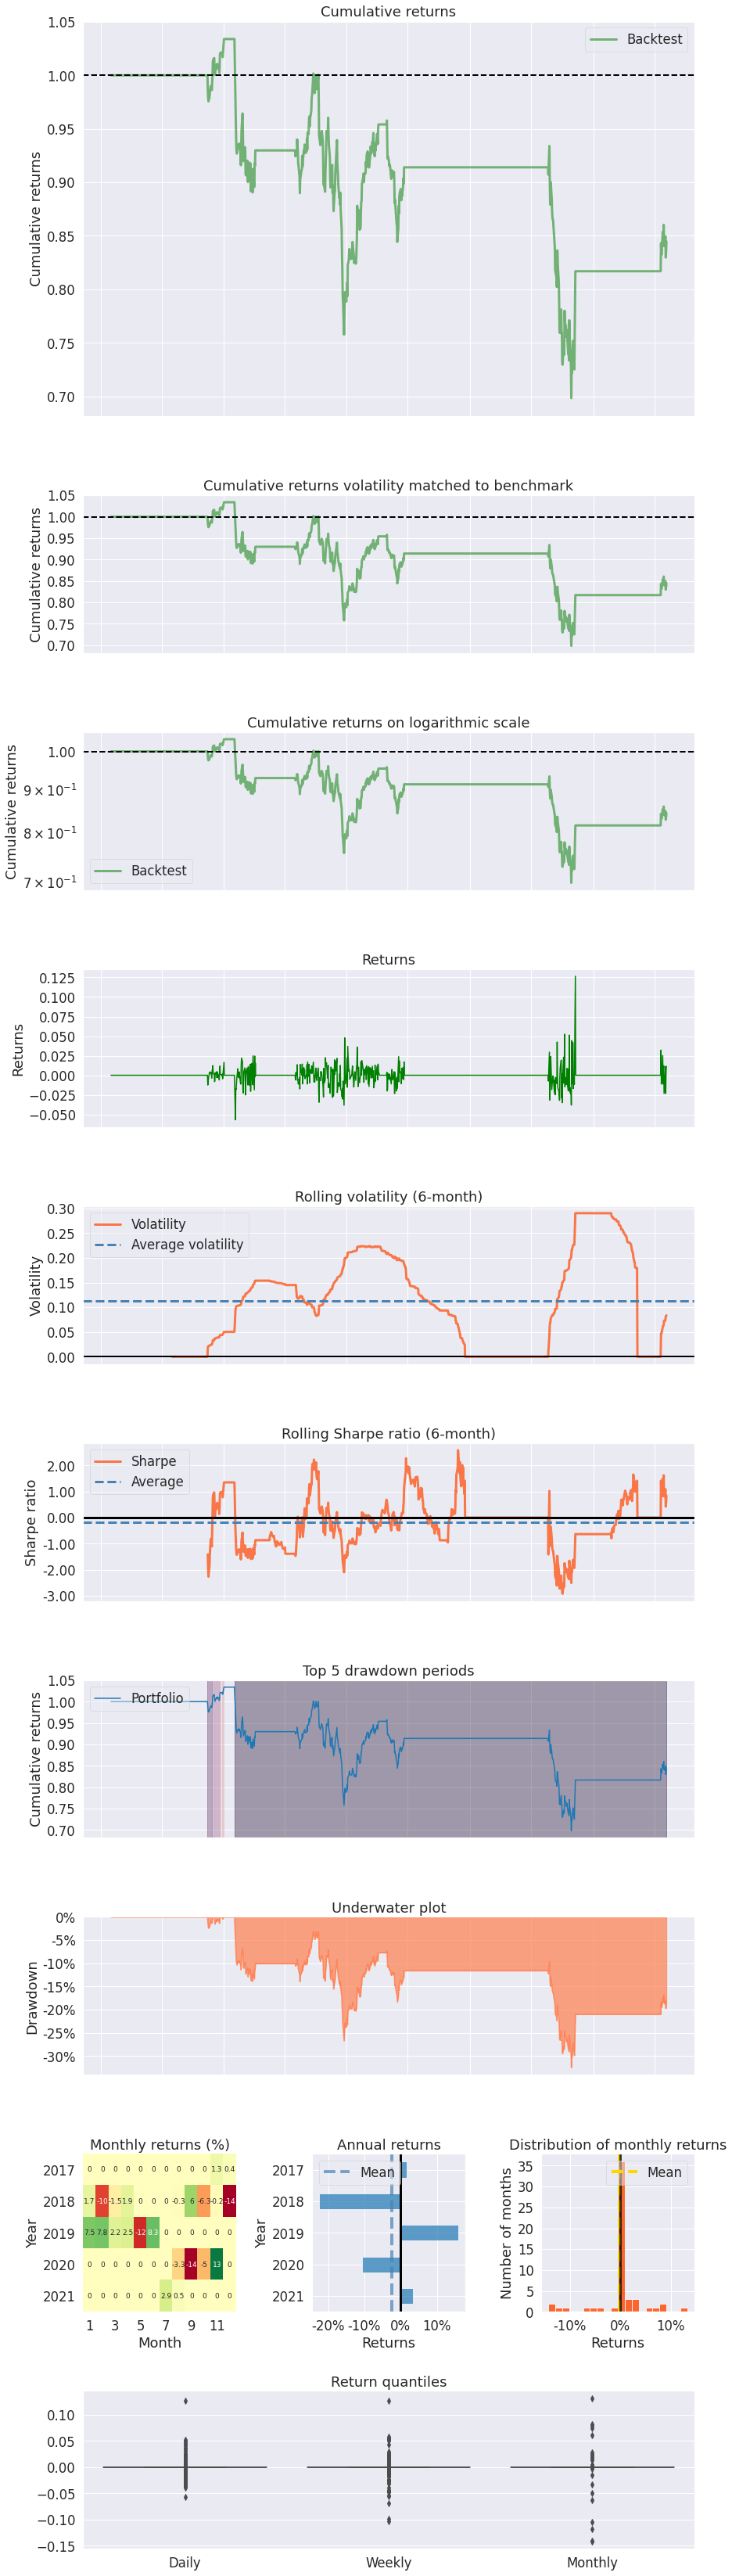

In [ ]:
ReversalsWithBollingerBand(get_price_df('XOM', '2017-01-01', '2021-08-08') )# Exxon Mobile stock

# **결론**
* %b와 일중강도 보조 지표를 이용해 천정과 바닥을 짚어내어 추세 반전을 알 수 있음. 

# **장점**
* 고점이라고 판단될 때 매도해서, 급격한 하락장을 피할 수 있음. 즉, MDD(특정 기간에 발생한 최고점에서 최저점까지의 가장 큰 손실)를 낮출 수 있음
* 저점이라고 판단될 때 매수해서, 수익률을 높일 수 있음. 

# **단점**
* 고점과 저점을 잘못 판단하여, 주가가 상승세일 때 매도로 수익을 못볼 수 있고, 주가가 하락세일 때 매수로 손실이 가능함.

# **개선방안**
* 투자를 안하고 있을 때, 해당 전략을 보완할 수 있는 다른 전략 이용. e.g. 듀얼 모멘텀 전략을 이용
* 볼린저밴드 매매기법 책에 나오는 W 패턴 분석. 